# Exploratory data analysis on wine quality dataset

This is an exploratory data analysis on podcast review dataset. The main purpose of this analysis is investigate the relationship between wine quality and physicochemical features of wine. In addition, a relationship between alcohol and other physicochemical features is studied. The applied models are limited to linear machine learning models.

The main research questions for the data analysis are:
- Can we identify a pattern for high quality wines?
- Can we predict wine quality with physicochemical parameters using linear models?
- Are there relationships between alcohol and other physicochemical features?

The main findings:
- There is no single strong physicochemical feature that dominates wine quality.
- High quality wines have higher alcohol level.
- The strongest connection to wine alcohol level is with wine density and fixed acidity.

My goal with this project is to practice conducting exploratory data analysis, data handling with sql and python, and visualization of data. The project is part of Turing collage Data science course curriculum.

**Contents**
1. [Importing packages and data](#1.-Importing-packages-and-data)

    1.1 [Database review](#1.1-Database-review)


2. [Data cleaning and preprocessing](#2.-Data-cleaning-and-preprocessing)
    
    2.1 [Data cleaning](#2.1-Data-cleaning)
    
    2.2 [Checking for outliers](#2.2-Checking-for-outliers)
    
    
3. [Exploratory data analysis](#3.-Exploratory-data-analysis)
    
    3.1 [Quality scores](#3.1-Quality-scores)
    
    3.2 [Alcohol level](#3.2-Alcohol-level)
    
    3.3 [Correlations between features](#3.3-Correlations-between-features)
    
    3.4 [ANOVA testing](#3.4-ANOVA-testing)

    
4. [Modelling](#4.-Modelling)
    
    4.1 [Predicting wine quality](#4.1-Predicting-wine-quality)
    
    4.2 [Predicting alcohol level](#4.2-Predicting-alcohol-level)

    
5. [Conclusion](#5.-Conclusion)


***
## 1. Importing packages and data

In [1]:
%load_ext nb_black
%matplotlib inline
from scipy.stats import kruskal, bartlett
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_curve,
    auc,
    mean_squared_error,
    mean_squared_log_error,
)
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
import scikit_posthocs as sp
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

sns.set(rc={"figure.figsize": (10, 6)})

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
import preprocessingtools

<IPython.core.display.Javascript object>

### 1.1 Database review

In [3]:
con = duckdb.connect()

<IPython.core.display.Javascript object>

In [4]:
con.sql(
    """
CREATE TEMP TABLE winequality
AS
SELECT * FROM read_csv_auto('archive/winequality-red.csv');
"""
)

<IPython.core.display.Javascript object>

In [5]:
con.sql(
    """
SELECT *
FROM winequality"""
)

┌───────────────┬──────────────────┬─────────────┬────────────────┬───┬────────┬───────────┬─────────┬─────────┐
│ fixed acidity │ volatile acidity │ citric acid │ residual sugar │ … │   pH   │ sulphates │ alcohol │ quality │
│    double     │      double      │   double    │     double     │   │ double │  double   │ double  │  int64  │
├───────────────┼──────────────────┼─────────────┼────────────────┼───┼────────┼───────────┼─────────┼─────────┤
│           7.4 │              0.7 │         0.0 │            1.9 │ … │   3.51 │      0.56 │     9.4 │       5 │
│           7.8 │             0.88 │         0.0 │            2.6 │ … │    3.2 │      0.68 │     9.8 │       5 │
│           7.8 │             0.76 │        0.04 │            2.3 │ … │   3.26 │      0.65 │     9.8 │       5 │
│          11.2 │             0.28 │        0.56 │            1.9 │ … │   3.16 │      0.58 │     9.8 │       6 │
│           7.4 │              0.7 │         0.0 │            1.9 │ … │   3.51 │      0.56 │    

<IPython.core.display.Javascript object>

In [6]:
con.sql("describe winequality")

┌──────────────────────┬─────────────┬─────────┬─────────┬─────────┬───────┐
│     column_name      │ column_type │  null   │   key   │ default │ extra │
│       varchar        │   varchar   │ varchar │ varchar │ varchar │ int32 │
├──────────────────────┼─────────────┼─────────┼─────────┼─────────┼───────┤
│ fixed acidity        │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │
│ volatile acidity     │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │
│ citric acid          │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │
│ residual sugar       │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │
│ chlorides            │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │
│ free sulfur dioxide  │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │
│ total sulfur dioxide │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │
│ density              │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │
│ pH                   │ DOUBLE      │ YES     │ NULL    │ NULL    │  NULL │

<IPython.core.display.Javascript object>

***
## 2. Data cleaning and preprocessing

### 2.1 Data cleaning

Here the data is checked for null values and duplicates.

In [7]:
con.sql(
    """SELECT
        COUNT(*) - COUNT('fixed acidity') +
        COUNT(*) - COUNT('volatile acidity') +
        COUNT(*) - COUNT('residual sugar') +
        COUNT(*) - COUNT('fixed acidity') +
        COUNT(*) - COUNT(chlorides) +
        COUNT(*) - COUNT('free sulfur dioxide') +
        COUNT(*) - COUNT('total sulfur dioxide') +
        COUNT(*) - COUNT(density) +
        COUNT(*) - COUNT(pH) +
        COUNT(*) - COUNT(sulphates) +
        COUNT(*) - COUNT(alcohol) +
        COUNT(*) - COUNT(quality) AS number_of_nulls
        FROM winequality
        """
)

┌─────────────────┐
│ number_of_nulls │
│      int64      │
├─────────────────┤
│               0 │
└─────────────────┘

<IPython.core.display.Javascript object>

No null values are found.

In [8]:
df_winequality = con.sql(
    """
SELECT *
FROM winequality"""
).df()

<IPython.core.display.Javascript object>

In [9]:
preprocessingtools.check_duplicated_rows(df_winequality)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4               7.4             0.700         0.00            1.90      0.076   
11              7.5             0.500         0.36            6.10      0.071   
27              7.9             0.430         0.21            1.60      0.106   
40              7.3             0.450         0.36            5.90      0.074   
65              7.2             0.725         0.05            4.65      0.086   
...             ...               ...          ...             ...        ...   
1563            7.2             0.695         0.13            2.00      0.076   
1564            7.2             0.695         0.13            2.00      0.076   
1567            7.2             0.695         0.13            2.00      0.076   
1581            6.2             0.560         0.09            1.70      0.053   
1596            6.3             0.510         0.13            2.30      0.076   

      free sulfur dioxide  

<IPython.core.display.Javascript object>

There are duplicate rows which are removed.

In [10]:
df_winequality.drop_duplicates(keep="first", inplace=True)
df_winequality

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


<IPython.core.display.Javascript object>

### 2.2 Checking for outliers

Next, outliers and anomalies are checked from each feature. 

First, the range of values are defined for each feature. The information of each feature are provided as a list below. Based on this information all feature values should be positive. In addition, quality score is defined from 0 to 10 and pH is defined between 0 and 14. 

Features of dataset (based on physicochemical tests):
1. fixed acidity (tartaric acid - g / dm^3)
2. volatile acidity (acetic acid - g / dm^3)
3. citric acid (g / dm^3)
4. residual sugar (g / dm^3)
5. chlorides (sodium chloride - g / dm^3
6. free sulfur dioxide (mg / dm^3)
7. total sulfur dioxide (mg / dm^3)
8. density (g / cm^3)
9. pH
10. sulphates (potassium sulphate - g / dm3)
11. alcohol (% by volume)
12. quality (score between 0 and 10)

#### Distribution of features

Next, the distribution of features are visualized.

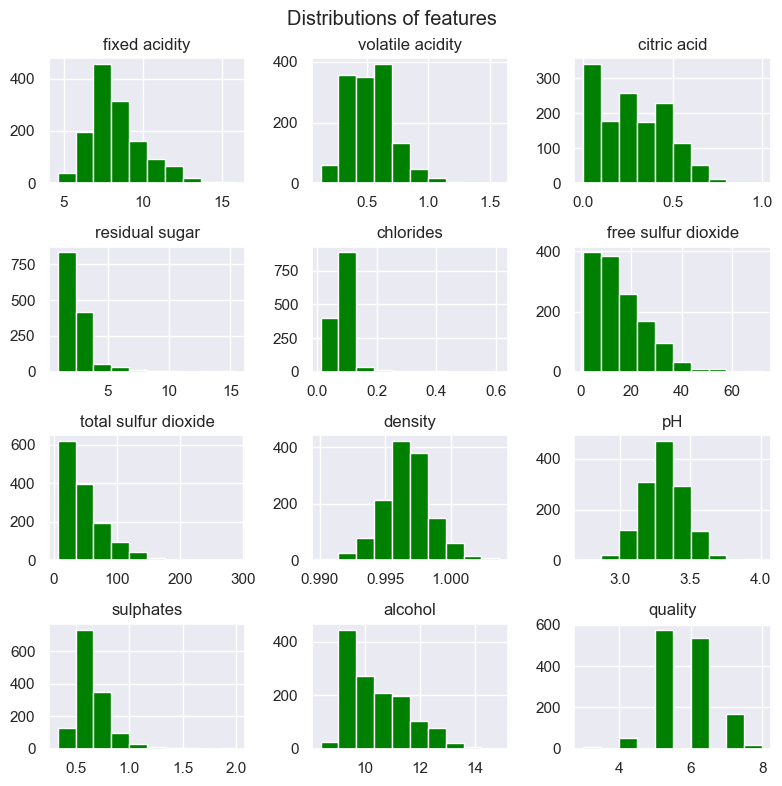

<IPython.core.display.Javascript object>

In [11]:
ax = pd.DataFrame.hist(df_winequality, figsize=[8, 8], color="green")
plt.tight_layout()
plt.suptitle("Distributions of features")
plt.subplots_adjust(top=0.92)

Based on the visual obervations, there are no outliers that should be removed from the dataset. Next, the summary statistics are checked.

#### Overview of statistics

In [12]:
df_winequality.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<IPython.core.display.Javascript object>

The summary statistics confirm the findings from the visual inspection. All the data points are kept for further analysis.

***
## 3. Exploratory data analysis

Next, the exploratory data analysis is conducted. The main interest are to identify patterns for high quality wine and relationship of alcohol level and other features.

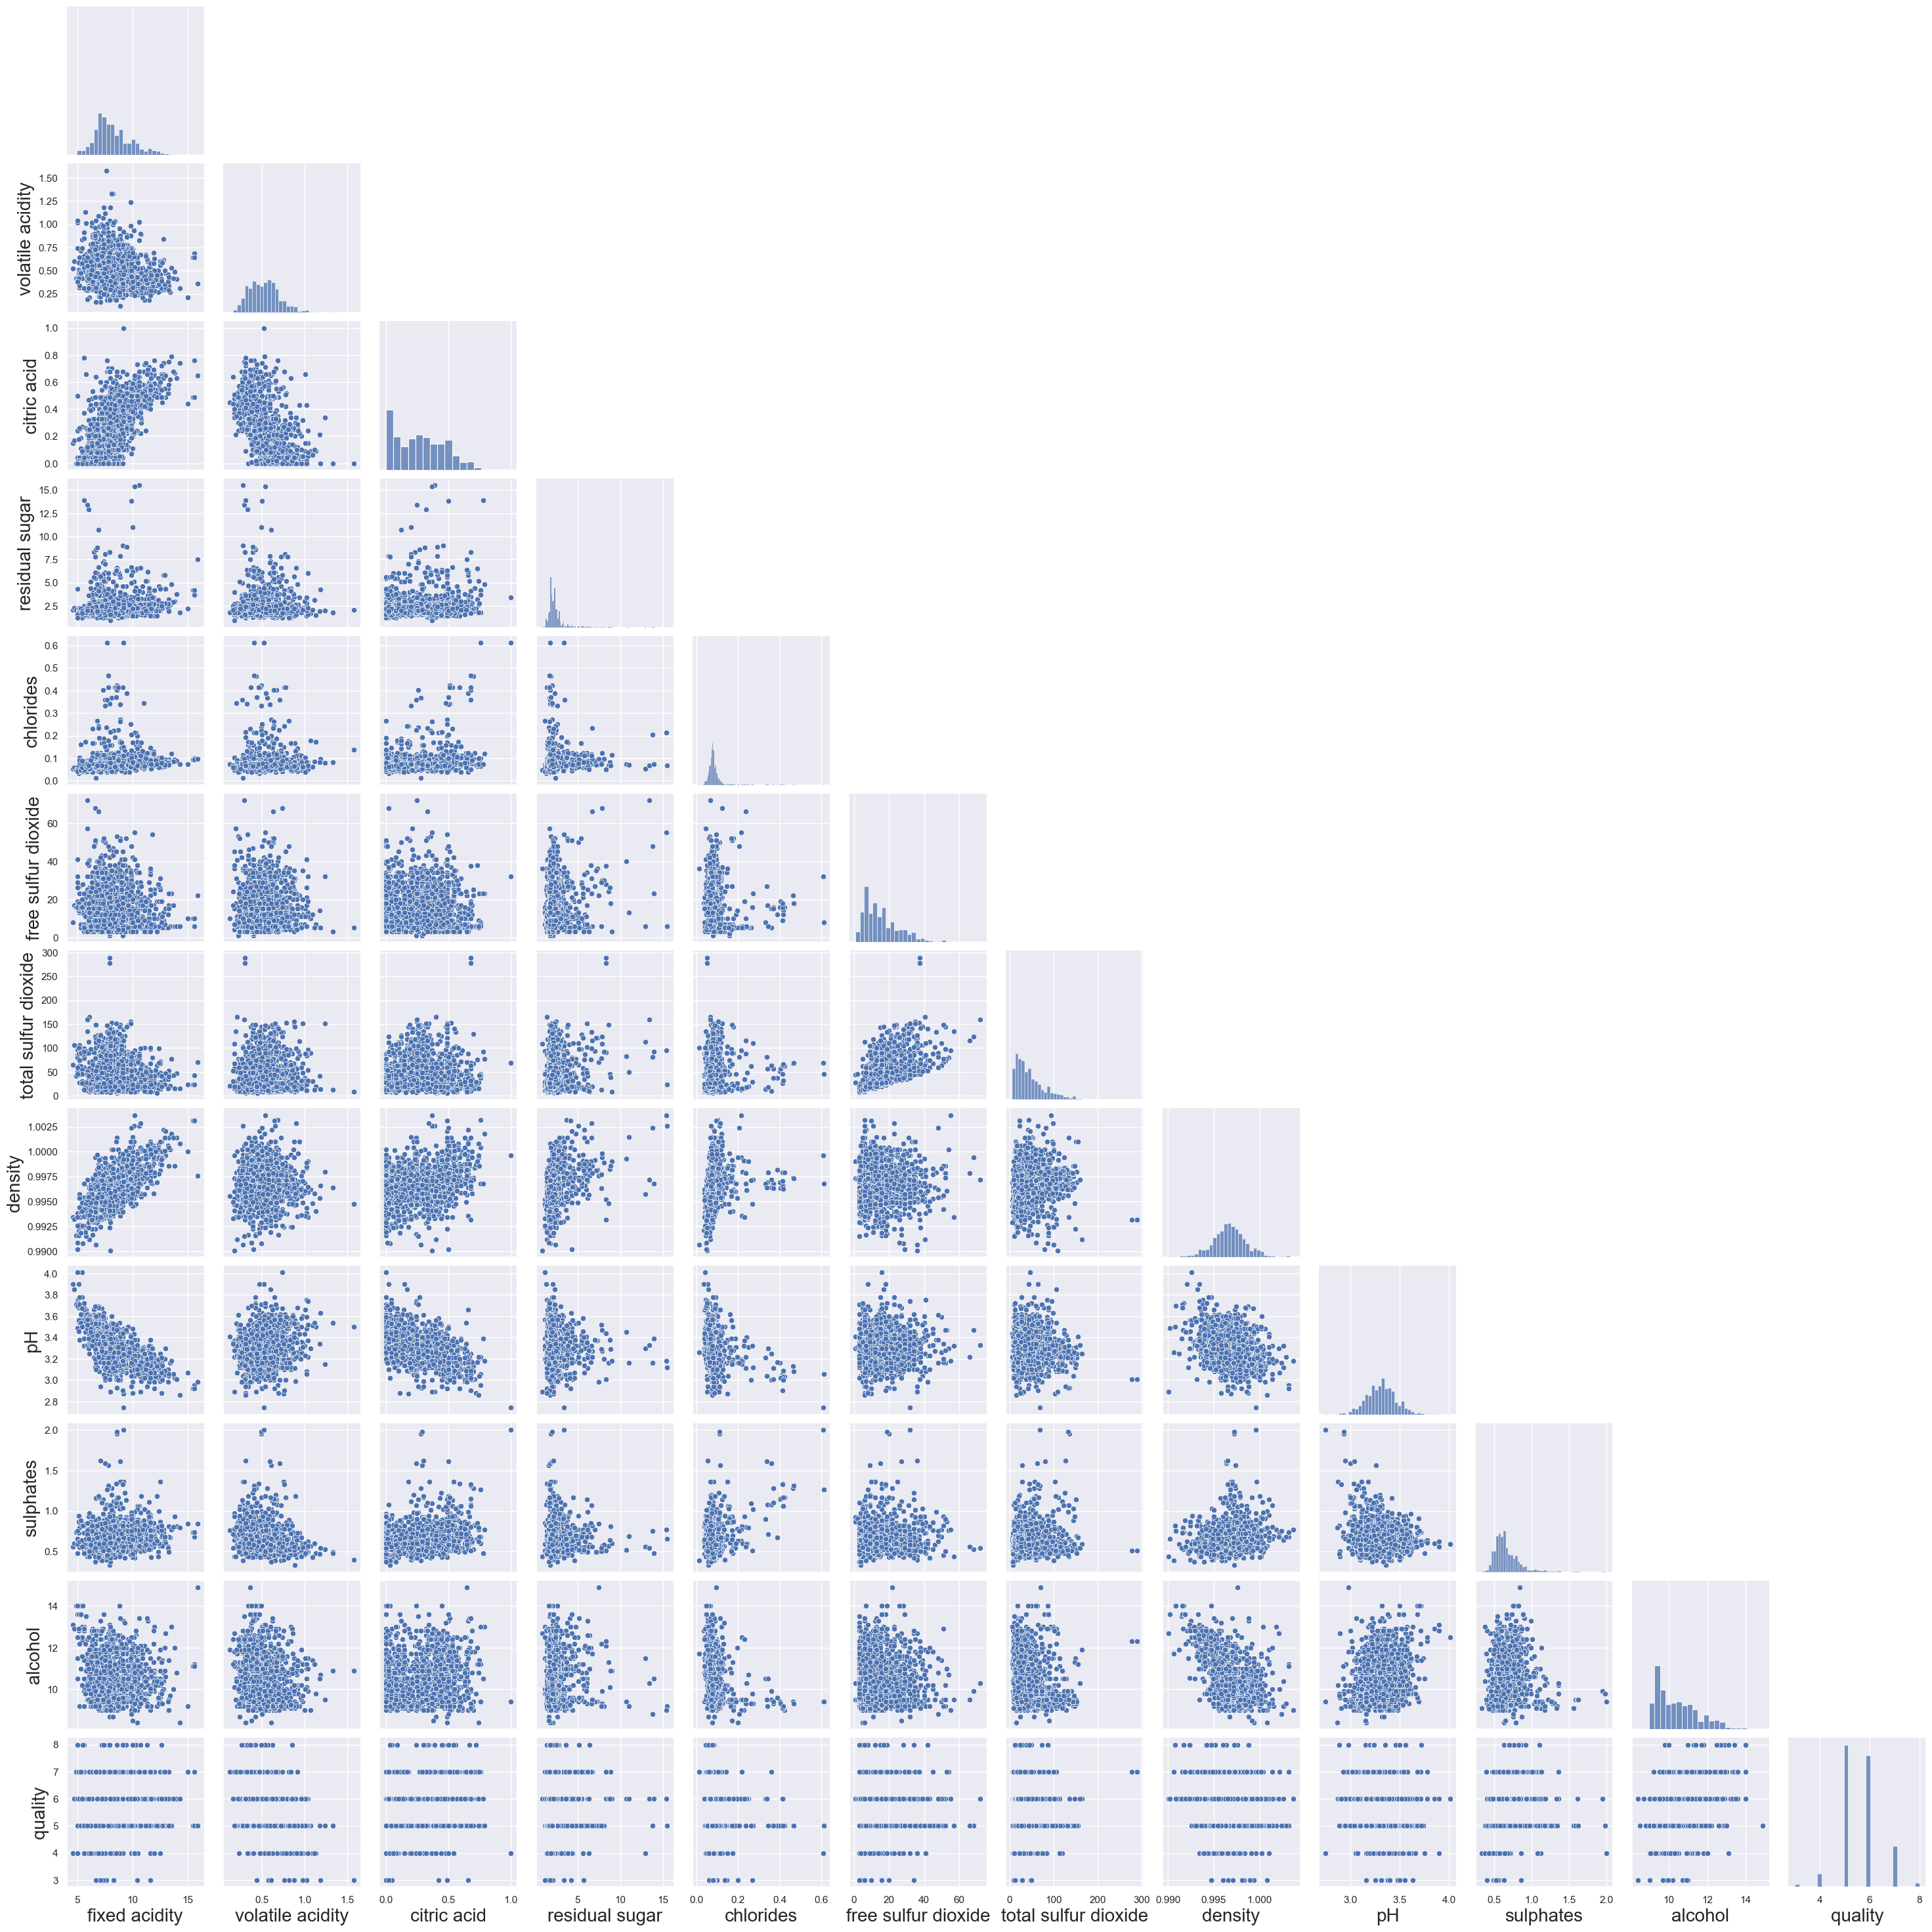

<IPython.core.display.Javascript object>

In [13]:
sns.set_context(rc={"axes.labelsize": 20})
g = sns.pairplot(df_winequality, corner=True)

Based on the scatter plots, it seems that there is no strong correlations between physicochemical features and wine quality. However, this is investigated more carefully in the next section. Similar findings are made also for alcohol level and other physicochemical features. 

### 3.1 Quality scores

First, the distribution of wine quality scores are investigated, and how the other physicochemical parameters vary between the scores.

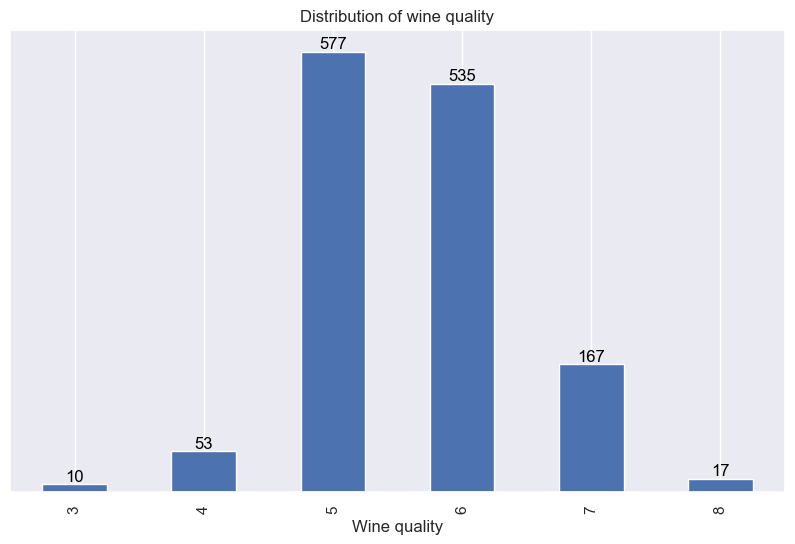

<IPython.core.display.Javascript object>

In [14]:
sns.set(rc={"figure.figsize": (10, 6)})
ax = (
    df_winequality.groupby("quality")["fixed acidity"]
    .count()
    .plot.bar(title="Distribution of wine quality")
)
ax.set_yticks([])
ax.set_xlabel("Wine quality")
for container in ax.containers:
    ax.bar_label(container, padding=0, color="black")

As can be seen, the quality points are concentrated on points 5 and 6. The distribution seems to be normally distributed. The minimum quality is three and maximum 8 in the dataset. Next, the distributions of physicochemical parameters are plotted for each quality score and compared.

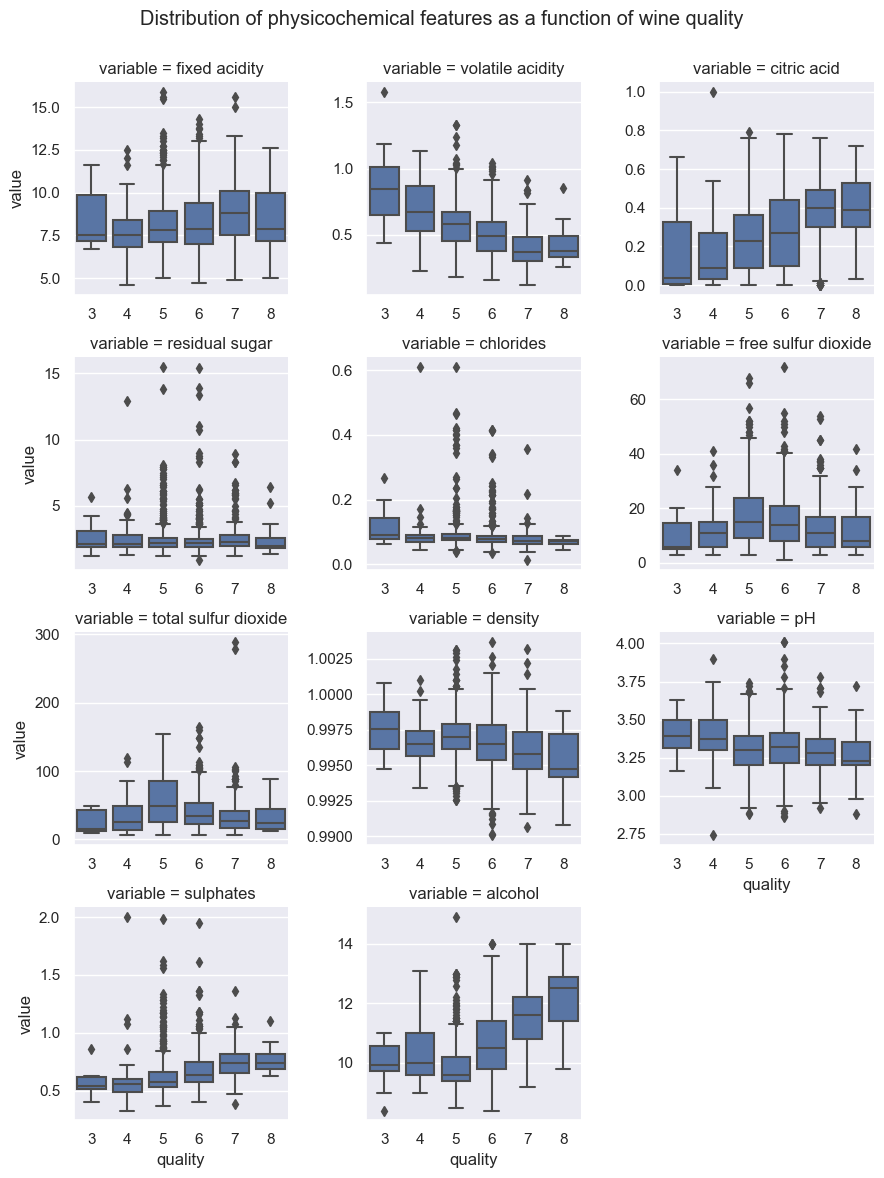

<IPython.core.display.Javascript object>

In [15]:
dfm = df_winequality.melt(id_vars="quality")

g = sns.FacetGrid(
    dfm,
    col="variable",
    col_wrap=3,
    sharex=False,
    sharey=False,
)
g.map(sns.boxplot, "quality", "value", order=[3, 4, 5, 6, 7, 8])
plt.suptitle("Distribution of physicochemical features as a function of wine quality")
plt.subplots_adjust(top=0.92)

Based on the distribution comparison, sulphates, alcohol and citric acid seem to have a positive correlation with wine quality. In contract, volatile acidity and chlorides seem to have a negative correlation with wine quality. Though, there is a lot of outliers in sulphates and chlorides values.

There is also a small declining trend in density and pH values. However, the range of the values are relatively small which makes it hard to make any conclusions with this information. Let's investigate these more later on.

This analysis concludes that higher wine quality tend to have lower level of volatile acidity, and sligtly more sulphates. Also higher alcohol and citric acid levels can be identified for higher wine quality but there is more scattering in the distributions.

### 3.2 Alcohol level

Next, the relationship of other features to the alcohol level is investigated.

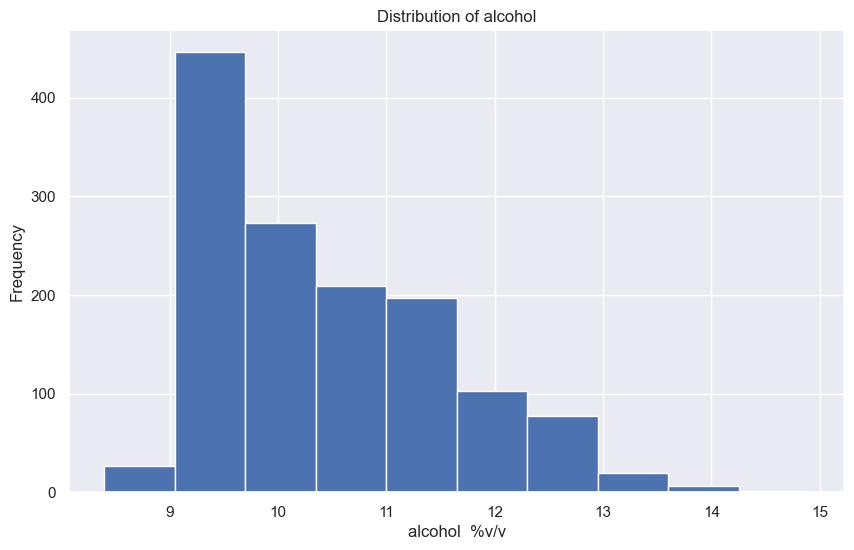

<IPython.core.display.Javascript object>

In [16]:
ax = df_winequality["alcohol"].plot.hist(title="Distribution of alcohol")
ax.set_xlabel("alcohol  %v/v")

In [18]:
df_winequality[["alcohol"]].agg(["count", "mean", "median", "std", "min", "max"]).T

,count,mean,median,std,min,max
alcohol,1359.0,10.432315,10.2,1.082065,8.4,14.9


<IPython.core.display.Javascript object>

As can be seen, the alcohol distributin is sliglty skewed to the right. Minimum values is about 8.4 and maximum a bit under 15 %v/v. Mean alcohol level is about 10.4 %v/v.

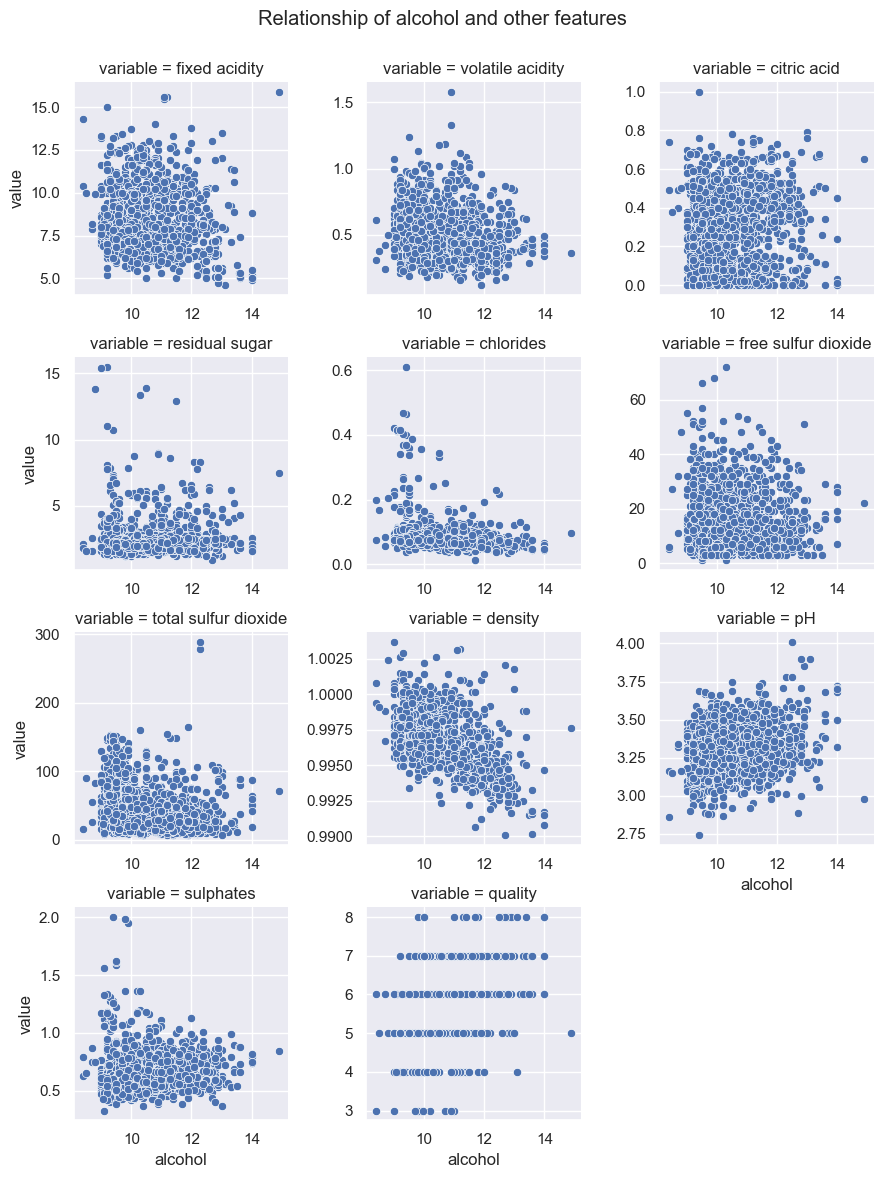

<IPython.core.display.Javascript object>

In [19]:
dfm = pd.melt(df_winequality, id_vars=["alcohol"])
g = sns.FacetGrid(
    dfm,
    col="variable",
    col_wrap=3,
    sharex=False,
    sharey=False,
)
g.map(
    sns.scatterplot,
    "alcohol",
    "value",
)
plt.suptitle("Relationship of alcohol and other features")
plt.subplots_adjust(top=0.92)

Most clear correlation can be seen with alcohol and density. This comes naturally as the alcohol has smaller density than water. Therefore the wines density decreases as the alcohol level increases. However, it should be noted that the range of density is very small. From the other features there is no clear pattern with alcohol level. Residual sugars and chlorides have a weak decreasing trend. The variation decreases in their distributions with higher alcohol level also. Similar finding can be made for free sulfur dioxide and total sulfur dioxides.

As there is large variation between the alcohol and other parameters, let's look at the correlation coefficients next.

### 3.3 Correlations between features

Here the correlation coefficient matrix is presented.

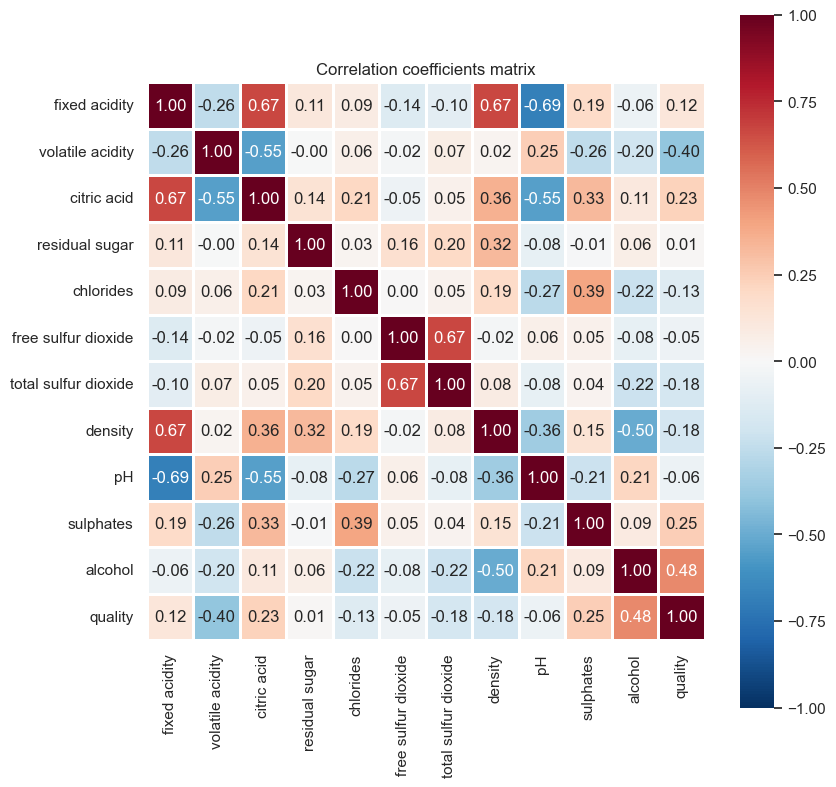

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(9, 9))
plt.title(
    "Correlation coefficients matrix",
)
ax = sns.heatmap(
    df_winequality.corr(),
    vmin=-1,
    vmax=1,
    linewidths=1,
    square=True,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)

As can be seen from the matrix, there is some correlation between features. Moderate positive correlation are between
- citric acid and fixed acidity,
- density and fixed acidity,
- free sulfur dioxide and total sulfur dioxide.

Moderate negative correlation between 
- pH and fixed acidity,
- pH and citric acidity,
- alcohol and density,
- citric acidity and volatile acidity.

These correlations can affect the model building and are addressed later on.

However, between our target variables alcohol and wine quality and other physicochemical features, there is no strong correlation. One reason for this can be that there is no single feature that has great impact on the alcohol level or wine quality, so all the features are as important. For wine quality, the strongest correlation is with alcohol level.

However, based on visual observations, some interesting features were identified. For wine quality, this would be:
- volatile acidity,
- chlorides,
- sulphates,
- alcohol,
- citric acid,
            
For alcohol level:
- density

### 3.4 ANOVA testing

As mentioned earlier, the density and pH values are investigated further. The values seem to decrease as wine quality increase. However, is the difference statistically significant? Here, this is studied and answered. 

The mean values of density and pH on different wine qualities are investigated with ANOVA test. The purpose is to identify if there is a statistically significant difference in the mean values between different wine qualities. However, as the quality scores are concentrated on few scores a new quality feature is created for this analysis. The wine qualities are divided in to three groups to ensure large enough group sizes and meaningful testing. The groups are
- low wine quality with quality score equal or below 4.
- medium wine quality with quality score above 4 but below 7.
- high quality wine with quality scores above seven.

Next, let's check if the assumptions of ANOVA test are fulfilled.

First, to improve test accuracy the subgroups need to have same size. Therefore, a new sample with 50 wines for each quality class is drawn. 

Then the assumption of same variance is checked visually and with Bartlett's test. It tests if samples have equal variance.

In [21]:
df_anova = df_winequality[["quality", "density", "pH"]].copy()

<IPython.core.display.Javascript object>

In [22]:
df_anova.loc[df_anova["quality"] <= 4, "quality_class"] = "low"
df_anova.loc[
    (df_anova["quality"] > 4) & (df_anova["quality"] < 7), "quality_class"
] = "med"
df_anova.loc[df_anova["quality"] >= 7, "quality_class"] = "high"
df_anova = df_anova.drop(columns="quality")
df_anova.quality_class.value_counts()

med     1112
high     184
low       63
Name: quality_class, dtype: int64

<IPython.core.display.Javascript object>

In [23]:
categories = df_anova.quality_class.unique()
sample_size = 50
seed = 50
sample_list = []
sample_density_dist = []
sample_ph_dist = []
for cat in categories:
    sample_list.append(
        df_anova[df_anova["quality_class"] == cat].sample(
            sample_size, random_state=seed
        )
    )
    sample_density_dist.append(sample_list[-1].density.values)
    sample_ph_dist.append(sample_list[-1].pH.values)
df_anova = pd.concat(sample_list)
df_anova.quality_class.value_counts()

med     50
high    50
low     50
Name: quality_class, dtype: int64

<IPython.core.display.Javascript object>

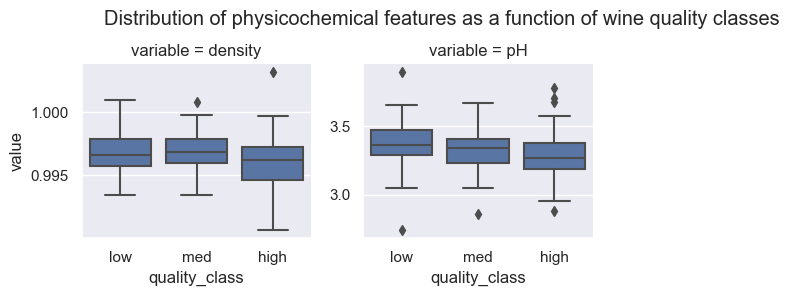

<IPython.core.display.Javascript object>

In [24]:
dfm = df_anova.melt(id_vars="quality_class")

g = sns.FacetGrid(
    dfm,
    col="variable",
    col_wrap=3,
    sharex=False,
    sharey=False,
)
g.map(sns.boxplot, "quality_class", "value", order=["low", "med", "high"])
plt.suptitle(
    "Distribution of physicochemical features as a function of wine quality classes"
)
plt.subplots_adjust(top=0.80)

In [25]:
print("Density:")
bartlett(*sample_density_dist)

Density:


BartlettResult(statistic=8.476401377709083, pvalue=0.014433538920126965)

<IPython.core.display.Javascript object>

In [26]:
print("pH:")
bartlett(*sample_ph_dist)

pH:


BartlettResult(statistic=1.256210022650179, pvalue=0.5336020133062843)

<IPython.core.display.Javascript object>

It seems that the assumption of equal variance is not fulfilled completely. For density, the assumptions is not fulfilled as the small p-values of Bartlett's test indicates. For the pH values the assumptions is fulfilled. Because the assumption is not fulfilled for all the desired features, instead of ANOVA test a Kruskal-Wallis test is used. 

Kruskal-Wallis test is a nonparametric equivalent of one-way ANOVA. Assumptions for Kruskal-Wallis are ordinal variables, Independence of groups and sample size higher than five. All of them are met. As a downside of Kruskal-Wallis we are testing for median instead of mean.

- Target population: Portuguese "Vinho Verde" red wines
- Null hypothesis: There is no difference in the median rating of quality classes. All median ratings are equal.
- Alternative hypothesis: At least one of the medians is different from the rest.
- Significance level: $\alpha = 0.05$

In [27]:
kw_statistic, kw_pvalue = kruskal(*sample_density_dist)
print("Density:")
print(f"P-value of KW-test: {kw_pvalue}")
print(f"Test statistic of KW-test: {kw_statistic:.2f}")

Density:
P-value of KW-test: 0.058576856769701126
Test statistic of KW-test: 5.67


<IPython.core.display.Javascript object>

In [28]:
kw_statistic, kw_pvalue = kruskal(*sample_ph_dist)
print("pH:")
print(f"P-value of KW-test: {kw_pvalue}")
print(f"Test statistic of KW-test: {kw_statistic:.2f}")

pH:
P-value of KW-test: 0.015549562177369912
Test statistic of KW-test: 8.33


<IPython.core.display.Javascript object>

Based on the result, it seems that the null hypothesis can be rejected with pH values. The median pHs of wine quality classes are not equal and at least one of the groups has statistically significantly different pH distributions. However, for wine density, there is not statistically significant difference between the groups.

Next, let's identify which of the wine qualities have significantly different median values. This can be conducted with Dunn's test.

- Target population: Portuguese "Vinho Verde" red wines
- Null hypothesis: Medians of compared groups are equal.
- Alternative hypothesis: Medians of compared groups are not equal.
- Significance level: $\alpha = 0.05$

Based on the result, it seems that with some of the compared pairs the null hypothesis can be rejected with 95% confidence. The tests indicates that low quality and high quality wines have statistically significantly different pH distributions. In other cases, the null hypothesis can not be rejected which means that there is no statistically significant difference between the distributions.

This means that for high quality wines the pH values are smaller than for low quality wines, but the difference between mediocre and high quality wines is not significant.

In [29]:
dunn_p_matrix = sp.posthoc_dunn(
    df_anova, val_col="pH", group_col="quality_class", p_adjust="bonferroni"
)
print("P-values of Dunn's test:")
dunn_p_matrix

P-values of Dunn's test:


,high,low,med
high,1.000000,0.011741,0.402577
low,0.011741,1.000000,0.496094
med,0.402577,0.496094,1.000000


<IPython.core.display.Javascript object>

****
## 4. Modelling

Next, the relationships of wine quality and physicochemical features and the relationship of alcohol and other physicochemical features are investigated further by modelling the relationship with linear models.

### 4.1 Predicting wine quality

As the wine quality scores are concentrated on two scores, the data is very unbalanced. The division used in the previous section is not good for modelling as the distribution is still very unbalanced. Therefore, a new quality feature is created. The wine qualities are divided in to two groups: high quality (six or higher) and low quality wines (lower than six). 

After that, the data is split into training and testing sets. Then a classifier model is created to predict the wine quality. The used model is logistic refression. Lastly, the predictor features are standardized to have zero mean and standard deviation of one to improve numerical stability of the model.

The model is fit with training data and finally assessed with test data.

- Target population:  Portuguese "Vinho Verde" red wines
- Significance level: $\alpha = 0.05$

Assumptions for the logistic regression are fulfilled.
- Target variable is binary.
- Observations are independent from each other.
- Enough large sample size.
- Multicollinearity among the independent variables. As discussed previously there is some correlation between the predictors. However, as the correlation is not strong we will leave these predictors to the model.


In [30]:
df_modelling = df_winequality.copy()
df_modelling.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [31]:
df_modelling.loc[df_modelling["quality"] < 6, "quality_label"] = 0.0
df_modelling.loc[df_modelling["quality"] >= 6, "quality_label"] = 1.0
df_modelling = df_modelling.drop(columns="quality")
df_modelling.quality_label = df_modelling.quality_label.astype(float)
df_modelling.quality_label.value_counts()


1.0    719
0.0    640
Name: quality_label, dtype: int64

<IPython.core.display.Javascript object>

In [32]:
pd.options.display.float_format = "{:.2f}".format

<IPython.core.display.Javascript object>

In [33]:
Xs_log = df_modelling.drop(columns=["quality_label"])

<IPython.core.display.Javascript object>

In [34]:
Y_log = df_modelling["quality_label"].astype(float)

<IPython.core.display.Javascript object>

In [35]:
scaler = StandardScaler()
standardized_values = scaler.fit_transform(Xs_log)
Xs_log_standardized = pd.DataFrame(standardized_values, columns=Xs_log.columns)

<IPython.core.display.Javascript object>

In [36]:
Xs_log_standardized = sm.add_constant(Xs_log_standardized)
Xs_log_standardized.describe()

,const,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00
mean,1.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00
std,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,1.00,-2.14,-2.24,-1.39,-1.20,-1.54,-1.43,-1.22,-3.55,-3.68,-1.93,-1.88
25%,1.00,-0.70,-0.76,-0.93,-0.46,-0.37,-0.85,-0.74,-0.59,-0.64,-0.64,-0.86
50%,1.00,-0.24,-0.05,-0.06,-0.24,-0.18,-0.18,-0.26,-0.00,0.00,-0.23,-0.21
75%,1.00,0.51,0.60,0.81,0.06,0.06,0.49,0.48,0.59,0.58,0.42,0.62
max,1.00,4.37,5.74,3.72,9.60,10.59,5.37,7.25,3.74,4.52,7.86,4.13


<IPython.core.display.Javascript object>

Data is divided to training and testing sets.

In [37]:
x_log_train, x_log_test, y_log_train, y_log_test = train_test_split(
    Xs_log_standardized, Y_log, test_size=0.30, random_state=4, stratify=Y_log
)

<IPython.core.display.Javascript object>

In [38]:
log_model = sm.GLM(y_log_train, x_log_train, family=sm.families.Binomial())

<IPython.core.display.Javascript object>

In [39]:
log_results = log_model.fit()

<IPython.core.display.Javascript object>

In [40]:
print(log_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          quality_label   No. Observations:                  951
Model:                            GLM   Df Residuals:                      939
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -495.43
Date:                Fri, 21 Apr 2023   Deviance:                       990.87
Time:                        12:01:10   Pearson chi2:                 1.25e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2890
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2575 

<IPython.core.display.Javascript object>

Based on the training results and significance level, five of eleven predictors do not have significant relationship with the dependent variable. These are:
- fixed acidity
- citric acid
- residual sugar
- density
- pH

Based on their p-values and confidence intervals the null hypothesis for these values is not rejected. Therefore, it can not be concluded that these predictors have a significantly linear relationship with log odds of the probability of being classified as a high quality wine.

Predictors that have significantly linear relationship with log-odds of the probability to be classified as a high quality wine are:
- volatile acidity
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- sulphates
- alcohol
For these predictors, the null hypothesis can be rejected. The regression coefficient are not equal to zero. 

The model confirms clearly EDA findings that were made for alcohol, sulphates, and volatile acidity. All the predictors have large coefficients (negative or positive) and p-value close to zero. The relationship of chlorides and free sulfur dioxide are not that strong to the wine quality even though the coefficients are statistically significant. A new finding is that total sulfur dioxide has the largest negative impact to the wine quality. 

The pseudo R-squared value of the model is quite low. That suggests that the model explains a low amount of the variance in the wine quality.

In [41]:
yhat = log_results.predict(x_log_test)
prediction = list(map(round, yhat))

<IPython.core.display.Javascript object>

In [42]:
print("Confusion Matrix : \n", confusion_matrix(y_log_test, prediction))
print("Test accuracy = ", accuracy_score(y_log_test, prediction))

Confusion Matrix : 
 [[140  52]
 [ 48 168]]
Test accuracy =  0.7549019607843137


<IPython.core.display.Javascript object>

The accuracy of the model is not too bad. Accuracy is a good metric for our model as the new target variable division is rather balanced. Other metrics for the model are presented below. The model seems to be more inaccurate in predicting wines in low quality class.

In [43]:
print(classification_report(y_log_test, prediction))

              precision    recall  f1-score   support

         0.0       0.74      0.73      0.74       192
         1.0       0.76      0.78      0.77       216

    accuracy                           0.75       408
   macro avg       0.75      0.75      0.75       408
weighted avg       0.75      0.75      0.75       408



<IPython.core.display.Javascript object>

#### ROC curve

In [44]:
# false positive rate and true positive rate
fpr, tpr, threshold = roc_curve(y_log_test, yhat)
roc_auc = auc(fpr, tpr)

<IPython.core.display.Javascript object>

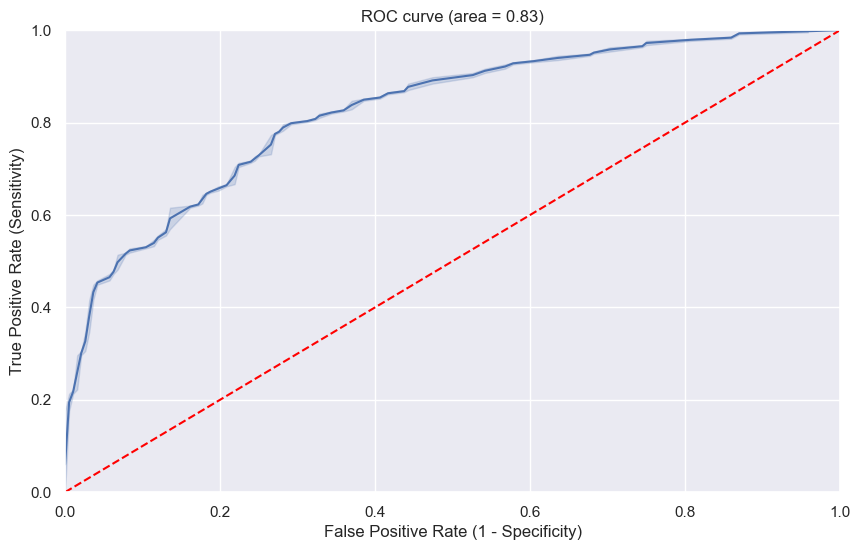

<IPython.core.display.Javascript object>

In [45]:
sns.lineplot(x=fpr, y=tpr)
sns.lineplot(x=[0, 1], y=[0, 1], color="red", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title(f"ROC curve (area = {roc_auc:.2f})")

The area under the ROC curve is rather high. As a rule of thumb it can be said that area larger than 0.7 can be considered as a good classifier.

#### Influential outliers

Let's next check if some of the datapoints have larger influence to the model. The influential outlier is here defined with Cook's distance with a threshold $4/N$.

In [46]:
cook_threshold = 4 / len(x_log_train)
cook_threshold

0.004206098843322818

<IPython.core.display.Javascript object>

In [47]:
influence = log_results.get_influence()
cook_distances = influence.summary_frame().loc[:, ["cooks_d"]]

<IPython.core.display.Javascript object>

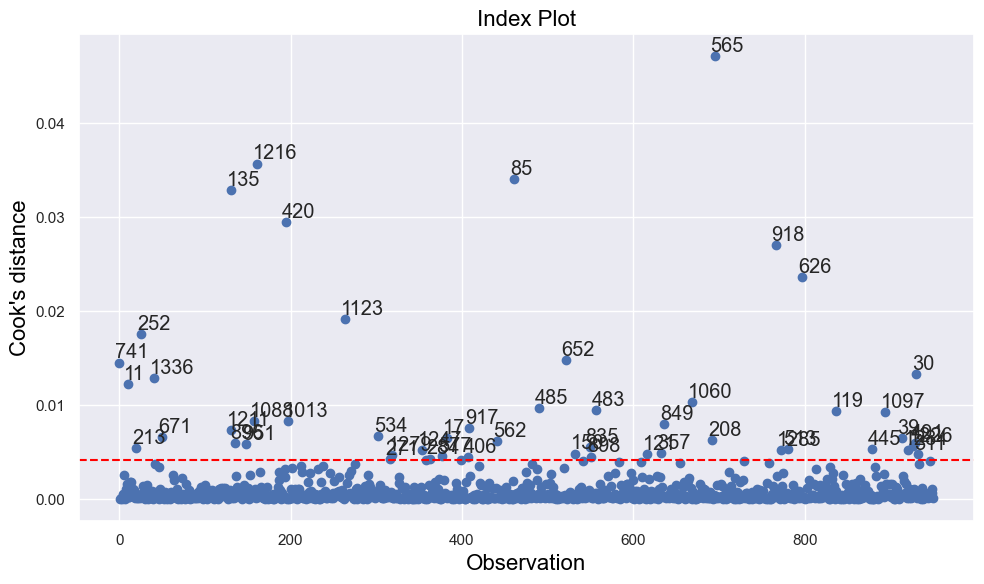

<IPython.core.display.Javascript object>

In [48]:
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y=cook_threshold, ls="--", color="red")
fig.tight_layout()

Here, the Cook's distance is plotted for all the observations in the training set together with index value.

Number of observations that exceed Cook's distance threshold is approximately 5%

In [49]:
outliers = cook_distances[cook_distances.values > cook_threshold]
prop_outliers = round(100 * (len(outliers) / len(x_log_train)), 1)
print(f"{prop_outliers}%")

5.4%


<IPython.core.display.Javascript object>

All in all, there is approximately 5 % of values with high Cook's distance. That's not too large value but it can affect to the model. However, with this information it is still hard to say if the values are anomalies or not and should they be removed.

The model predicts wine quality with a satisfactory level, but there is room for improvements, e.g. dealing influential outliers. The AUC value is above 0.7 which indicates that the classifier is good. The model results confirmed some of the relationship observations between physicochemical features and wine quality that were discovered already in EDA. For example, negative correlations of volatile acidity with wine quality. However, the results should be taken with care as there is still uncertainty in the model. 

### 4.2 Predicting alcohol level

Here, the relationships between alcohol and other physicochemical features are investigated further with linear regression model. 

First the data is split into training and testing data. The data is standardized to have zero mean and standard deviation of one to improve numerical stability of the model. Then a linear regression model is created. Fitted with training data and tested with testing data.

- Target population:  Portuguese "Vinho Verde" red wines
- Significance level: $\alpha = 0.05$

Assumptions for the linear regression are fulfilled or will be checked.
- Normally distributed residuals. This will be checked.
- Homoscedasticity, do the residuals have constant variation against target values? Will be checked.
- Observations are independent from each other.
- Enough large sample size.
- Multicollinearity among the independent variables. As discussed previously there is some correlation between the predictors. However, as the correlation is not strong we will leave these predictors to the model.


In [50]:
df_lm = df_winequality.copy()
df_lm.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [51]:
scaler = StandardScaler()
standardized_values = scaler.fit_transform(df_lm)
df_lm = pd.DataFrame(standardized_values, columns=df_lm.columns)

<IPython.core.display.Javascript object>

In [52]:
Xs_lm = df_lm.drop(columns=["alcohol", "quality"])
Xs_lm = sm.add_constant(Xs_lm)
Y_lm = df_lm["alcohol"]

<IPython.core.display.Javascript object>

In [53]:
x_lm_train, x_lm_test, y_lm_train, y_lm_test = train_test_split(
    Xs_lm, Y_lm, test_size=0.30, random_state=4
)

<IPython.core.display.Javascript object>

In [54]:
lm_model = sm.OLS(y_lm_train, x_lm_train)

<IPython.core.display.Javascript object>

In [55]:
lm_results = lm_model.fit()

<IPython.core.display.Javascript object>

In [56]:
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     209.7
Date:                Fri, 21 Apr 2023   Prob (F-statistic):          2.14e-231
Time:                        12:02:44   Log-Likelihood:                -777.23
No. Observations:                 951   AIC:                             1576.
Df Residuals:                     940   BIC:                             1630.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0067      0.018     -0.374      0.708      -0.042       0.028
fixed acidity            0.8466      0.042     20.086      0.000       0.764       0.929
volatile acidity         0.0321      0.024      1.358      0.175      -0.014       0.078
citric acid              0.1118      0.033      3.441      0.001       0.048       0.176
residual sugar           0.3919      0.021     18.966      0.000       0.351       0.433
chlorides               -0.0567      0.021     -2.653      0.008      -0.099      -0.015
free sulfur dioxide     -0.0337      0.025     -1.352      0.177      -0.083       0.015
total sulfur dioxide    -0.0639      0.028     -2.321      0.020      -0.118      -0.010
density                 -1.0561      0.029    -36.349      0.000      -1.113      -0.999
pH                       0.5395      0.028     19.217      0.000       0.484       0.595
sulphates                0.2034      0.020     10.128      0.000       0.164       0.243
==============================================================================
Omnibus:                       59.455   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.468
Skew:                           0.474   Prob(JB):                     1.13e-21
Kurtosis:                       4.240   Cond. No.                         5.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

The model is created using all 10 physicochemical features. The calculated the R-squared value to measure the proportion of variance in the alcohol variable 0.69, which suggests that the model explains a moderate amount of the variance.

Finally, the statistical significance of each feature is assessed using p-values. Predictors that have p-value under the significance level are 
- fixed acidity
- citric acid
- residual sugar
- chlorides
- density
- pH
- sulphates

Predictors for which the null hypothesis can not be rejected are:
- constat
- volatile acidity
- free sulfur dioxide

The constant predictors regressoin coefficient and p-value suggest that it could be dropded out from the model in future when more tuning is conducted. The density has the largest coefficient and is statistically significant. This indicates that it may have stronger impact on alcohol level than other predictors. Next most important predictors for alcohol level are fixed acidity, pH, and residual sugar. All have positive relationship with the target value.

Next, the models performance is assessed.

In [57]:
y_lm_pred = lm_results.predict(x_lm_test)

<IPython.core.display.Javascript object>

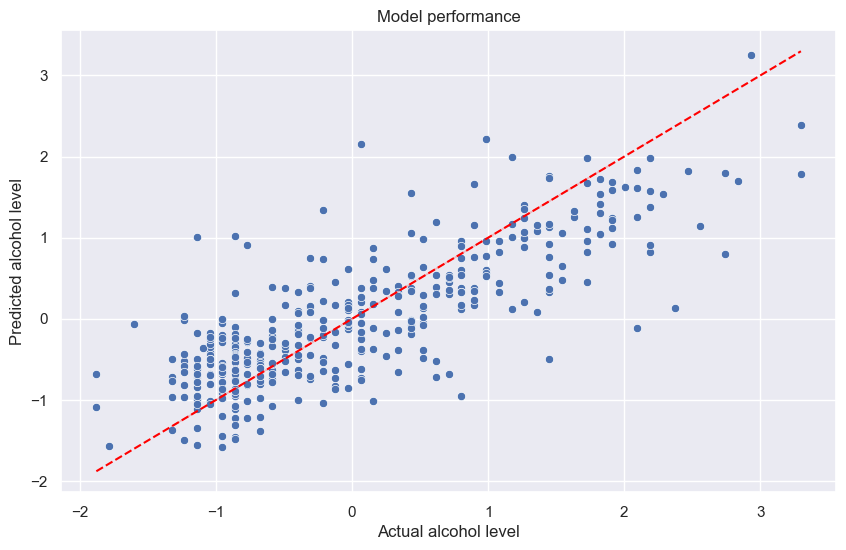

<IPython.core.display.Javascript object>

In [58]:
ax = sns.scatterplot(x=y_lm_test, y=y_lm_pred)
sns.lineplot(x=y_lm_test, y=y_lm_test, color="red", linestyle="--", ax=ax)
ax.set_xlabel("Actual alcohol level")
ax.set_ylabel("Predicted alcohol level")
ax.set_title("Model performance")

Based on the visual observations, it seems that the model is overestimating the alcohol level a bit especially in the higher end of the range.

In [59]:
print("Mean Squared Error (MSE): ", mean_squared_error(y_lm_test, y_lm_pred))
print(
    "Root Mean Squared Error (RMSE): ",
    np.sqrt(mean_squared_error(y_lm_test, y_lm_pred)),
)

Mean Squared Error (MSE):  0.3662146831420713
Root Mean Squared Error (RMSE):  0.6051567426229929


<IPython.core.display.Javascript object>

Values are rather high which indicates inaccuracy of the model.

#### Model assumptions
Next, the assumptions of the model are checked. First, the linearity and independence assumption is studied.

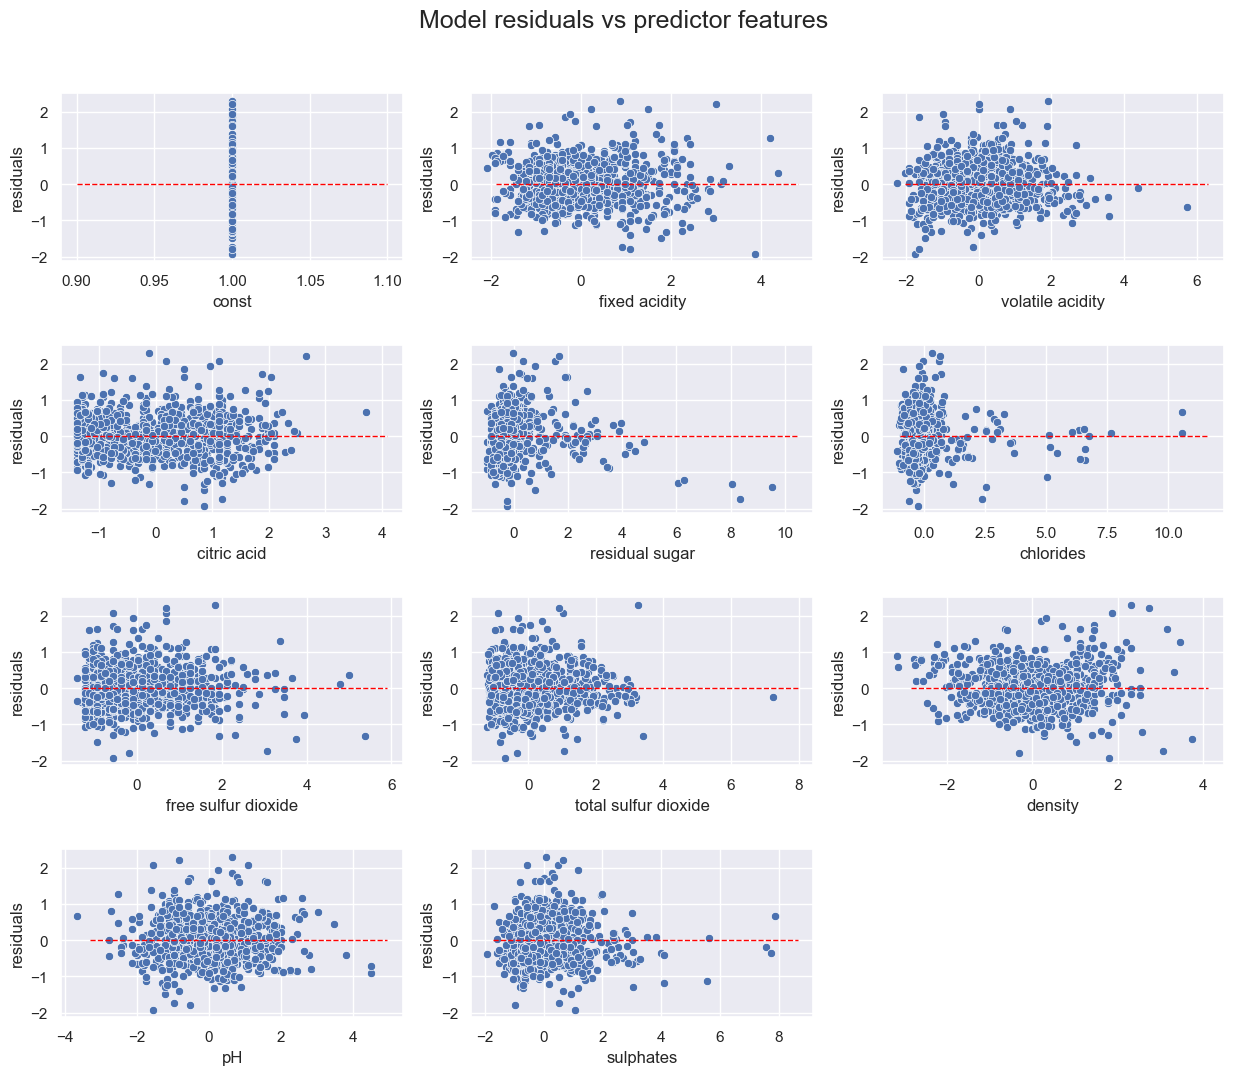

<IPython.core.display.Javascript object>

In [60]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Model residuals vs predictor features", fontsize=18, y=0.95)

for n, col in enumerate(x_lm_train.columns):
    ax = plt.subplot(4, 3, n + 1)
    sns.scatterplot(x=x_lm_train[col], y=lm_results.resid)
    xmin = min(x_lm_train[col]) * 0.9
    xmax = max(x_lm_train[col]) * 1.1
    plt.hlines(y=0, xmin=xmin, xmax=xmax, color="red", linestyle="--", lw=1)
    ax.set_xlabel(col)
    ax.set_ylabel("residuals")

Residuals are distributed randomly around zero and assumptions of linearity and indepencend are fulfilled.

Then the variance of residuals is checked.

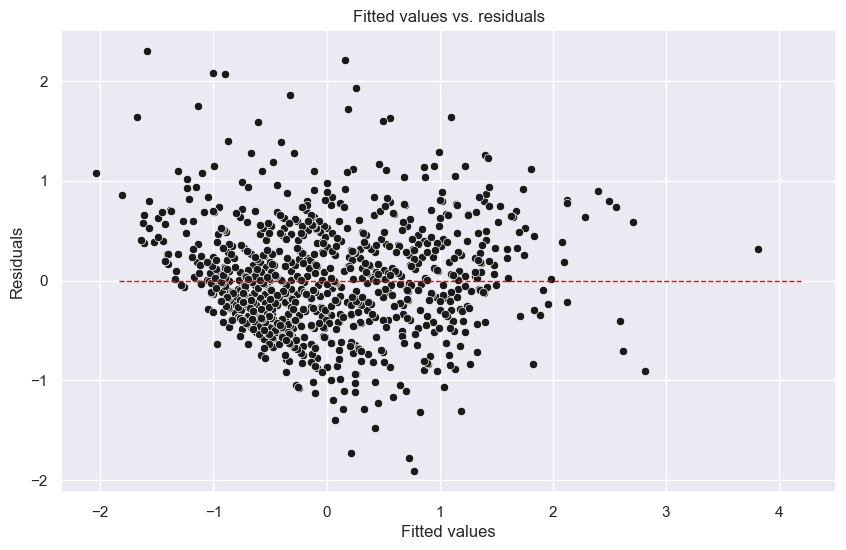

<IPython.core.display.Javascript object>

In [61]:
sns.scatterplot(
    x=lm_results.fittedvalues,
    y=lm_results.resid,
    color="k",
)
xmin = min(lm_results.fittedvalues) * 0.9
xmax = max(lm_results.fittedvalues) * 1.1
plt.hlines(y=0, xmin=xmin, xmax=xmax, color="red", linestyle="--", lw=1)
plt.title("Fitted values vs. residuals")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

The scatter plot shows that there is some kind of pattern with variance of residuals. Therefore, the assumption of homoscedasticity won't hold. This could mean that the model is not correctly explaining the target variables performance. One solution would be to add an additional predictor to improve the performance. However, in this case all the features are already included in the model.

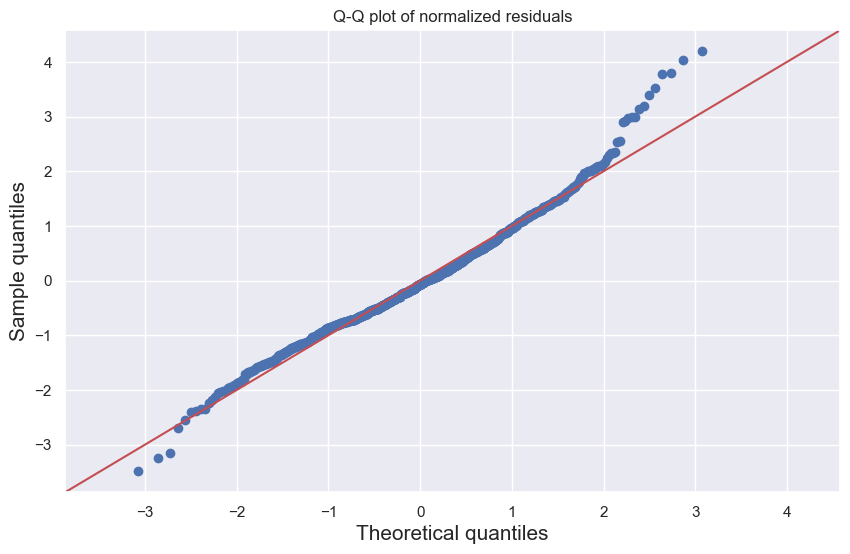

<IPython.core.display.Javascript object>

In [62]:
fig = qqplot(lm_results.resid_pearson, line="45", fit="True")
plt.xlabel("Theoretical quantiles", fontsize=15)
plt.ylabel("Sample quantiles", fontsize=15)
plt.title("Q-Q plot of normalized residuals")

The assumption of normally distributed residuals is checked visually. As can be seen from this Q-Q plot, the assumption is satisfied quite well.

#### Influential outliers

Let's next check if some of the datapoints have larger influence to the model. The influential outlier is here defined with Cook's distance with a threshold $4/N$.

In [63]:
cook_threshold = 4 / len(x_lm_train)
cook_threshold

0.004206098843322818

<IPython.core.display.Javascript object>

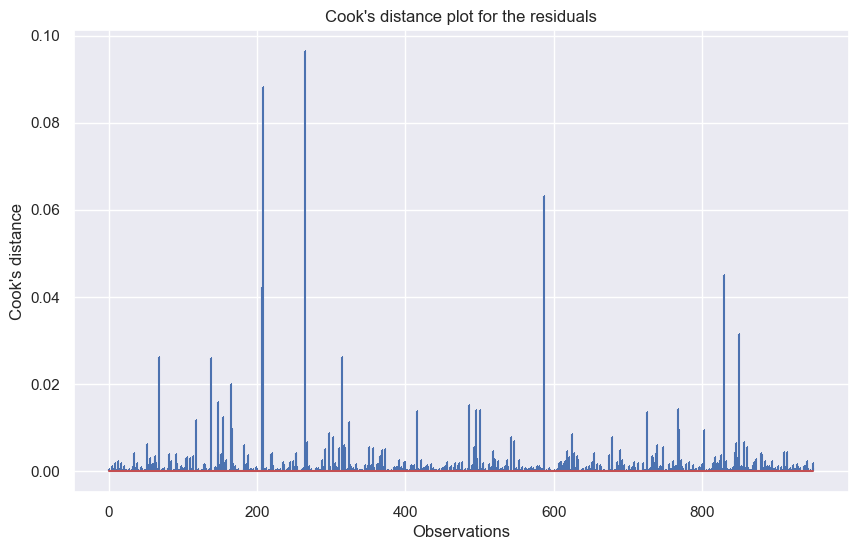

<IPython.core.display.Javascript object>

In [64]:
(cook_distances, p) = OLSInfluence(lm_results).cooks_distance
plt.title("Cook's distance plot for the residuals")
plt.xlabel("Observations")
plt.ylabel("Cook's distance")
plt.stem(np.arange(len(cook_distances)), cook_distances, markerfmt=",")
plt.grid(True)

Here, the Cook's distance is plotted for all the observations in the training set together with index value.

Number of observations that exceed Cook's distance threshold is approximately 6%

In [65]:
outliers = cook_distances[cook_distances.values > cook_threshold]
prop_outliers = round(100 * (len(outliers) / len(x_log_train)), 1)
print(f"{prop_outliers}%")

5.9%


<IPython.core.display.Javascript object>

All in all, there is approximately 6 % of values with high Cook's distance. That's not a too large value but it can affect to the model results. However, with this information it is still hard to say if the values are anomalies or not and should they be removed. This should be addressed in the future.

For conclusion it can be said that there is still a lot of issues with the model. The R-squared value is rather low, and the mean squared error is a bit high which indicates that there is still uncertainties in the model. The model showed that there is a clear negative correlation with wine density. This is natural as alcohol has lower density than water.

***
## 5. Conclusion

A data analysis is conducted to answer three main research questions:
1.	Can we identify a pattern for high quality wines?
2.	Can we predict wine quality with physicochemical parameters using linear models?
3.	Are there relationships between alcohol and other physicochemical features?


For the first question the main findings are:
-	There is no single strong physicochemical feature that dominates wine quality.


-	Higher wine qualities tend to have a higher level of alcohol. It has a medium correlation with the wine quality. It was also confirmed with linear model that alcohol level has the largest impact to identify wine quality. The mean alcohol level increases close to 12 %v/v for wine qualities of 7 and 8.


-	The wine quality model results show that total sulfur dioxide has a great negative impact on wine quality. However, based on the EDA both lowest and highest quality scores had low level of total sulfur dioxides.


-	Other important factors for wine quality are sulphates and volatile acidity. These are identified both in EDA and through linear modelling. Wines with higher quality scores have slightly high sulphate level, but there is a lot of scattering in the results.  Volatile acidity has a medium negative correlation with wine quality. 


-	Based on statistical testing, there is strong evidence that density does not have significant impact on wine quality. 


-	For pH, there is a significant difference between low and high quality wines, but not between low and medium or medium and high quality wines.


For the second question a logistic regression model is built. For its purpose, the wine qualities are divided into two groups: low- and high-quality wines.
-	The model performs sufficiently, but there is still room for improvement. Main problems are due to the unbalanced dataset. 


-	Test accuracy is 0.75 and AUC 0.83.

For the third question a linear regression model is built. The main findings are:
-	Based on EDA, there is a medium negative correlation between alcohol level and wine density. This is due to the fact that alcohol has lower density than water. The linear model confirmed this relationship.


-	Based on the model, the largest positive impact on alcohol level is fixed acidity. 


-	The model has a lot of uncertainties and hence the results should be taken with care.


-	Low R-squared value and high MSE.

As a conclusion, there is a pattern to identify high quality wines. The most important factors are higher alcohol level, and lower total sulfur dioxide level. With the classifier model the wine quality is determined with an accuracy of 0.75. The alcohol level of wine has negative correlation with wine density and a strong positive connection with fixed acidity, which increases e.g. tannins taste for the wine.


### For future remarks


- Dealing with high influential outliers
- Obtaining dataset that has more wine qualities at the top and lower end of the scale.
- Using feature selection to improve models accuracy.
- Identifying interaction effects between predictors to improve model accuracy.
- Using more sophisticated model for alcohol level.